<a href="https://colab.research.google.com/github/johyunkang/py_pandas/blob/main/python_ml_perfect_guide_05_bike_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 회귀 실습 - Bike Sharing Demand

컬럼 정보
- datetime : hourly date + timestamp
- season : 1=봄, 2=여름, 3=가을, 4=겨울
- holiday : 1=토,일요일의 주말을 제외한 국경일 등의 휴일, 0=휴일이 아닌 날
- workingday : 1=토, 일요일의 주말 및 휴일이 아닌 주중, 0=주말 및 휴일
- weather : 1=맑음, 약간 구름낀 흐림, 2=안개, 안개 + 흐림, 3=가벼운 눈, 가벼운비 + 천둥, 4=심한눈/비, 천둥/번개
- temp : 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity : 상대습도
- windspeed : 풍속
- casual : 사전에 등록되지 않는 사용자가 대여한 횟수
- registered : 사전에 등록된 사용자가 대여한 횟수
- count : 대여 횟수


#### 데이터 클렌징 및 가공

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/bike-sharing/train.csv')

print(df.shape)
print(df.info())
print(df.describe())
df

(10886, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
             season       holiday  ...    registered         count
count  10886.000000  10886.000000  ...  10886.000000  10886.000000
mean       2.506614      0.028569  ...    155.552177    191.574132
std        1.116174      0.166599 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


DF 간단히 EDA 결과
- NaN 컬럼 없음
- datetime 컬럼 만 object 형이라 가공 필요
- 나머지 컬럼은 전부 숫자인 int 또는 float 형


In [8]:
# 문자열을 datetime 타입으로 변경
df['datetime'] = df['datetime'].apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
df['year'] = df.datetime.apply(lambda x : x.year)
df['month'] = df.datetime.apply(lambda x : x.month)
df['day'] = df.datetime.apply(lambda x : x.day)
df['hour'] = df.datetime.apply(lambda x : x.hour)

df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22


In [9]:
# datetime 컬럼 삭제
# casual + registered = count 이므로 casual 과 registered 가 따로 필요하지 않아 삭제.
drop_columns = ['datetime', 'casual', 'registered']
df.drop(drop_columns, axis=1, inplace=True)

In [23]:
# 사이킷런은 RMSLE(Root Mean Square Log Error)를 제공하지 않아 만들겠음.
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log() 가 아닌 log1p()를 이용해 RMSLE 계산
# log1p() 는 1 + log() 값으로 log 변환값에 1을 더함.
def rmsle(y, pred) :
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred) :
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred) :
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)

    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE:{:.3f},  RMSE:{:.3f}, MAE:{:.3f}'.format(rmsle_val, rmse_val, mae_val))


위의 rmsle() 함수 만들 때 주의사항이 있음.  
rmsle를 구할 때 numpy 의 log() 함수를 이용하거나 사이킷런의 mean_squared_log_error()를 이용할 수도 있지만  
데이터 값의 크기에 따라 오버플로/언더플로 오류가 발생하기 쉬움.  
예를 들어 rmsle()를 다음과 같이 정의했을 때 오류가 발생할 수 있음.

In [16]:
# 다음과 같은 rmsle 구현은 오버/언더플로우 오류가 발생하기 쉬움
def rmsle_error(y, pred) :
    msle = mean_squared_log_error(y, pred)
    rmsle = np.sqrt(mse)
    return rmsle

#### 로그 변환, 피처 인코딩과 모델 학습 / 예측 / 평가

- 결과 값이 정규 분포로 되어 있는지 확인
- 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = df['count']
x_features = df.drop(['count'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)

evaluate_regr(y_test, pred)

RMSLE:1.165,  RMSE:140.900, MAE:105.924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


실제값과 예측값이 어느정도 차이가 나는지 오류 값이 가장 큰 순으로 5개만 확인

In [26]:
def get_top_error_data(y_test, pred, n_tops=5) :
    # DF 컬럼으로 실제 대여 횟수(count)와 예측 값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    # 예측값과 실제값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


가장 큰 상위 5개 오류 값이 546 ~ 568로 예측 오류가 꽤 큼.  
회귀에서 이렇게 오류 발생 시 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡됀 형태를 이루고 있는지 확인.  
pandas의 hist() 를 이용해 count 값이 정규 분포를 이루고 있는지 확인


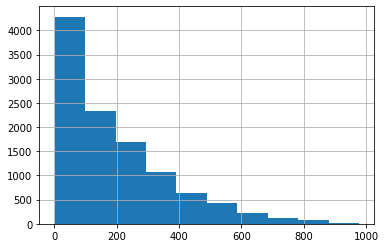

In [27]:
y_target.hist()

count 컬럼 값이 정규 분포가 아닌 0 ~ 200 사이에 왜곡돼 있는 것을 알 수 있음.  
log1p()를 이용해 정규 분포 형태로 바꾸겠음. 이렇게 변경된 Target 값을 기반으로 학습하고  
예측한 값은 다시 **expm1()** 함수를 적용해 원래 **scale** 값으로 원상 복구하면 됨.

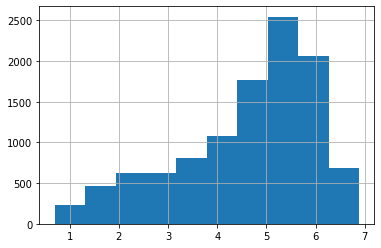

In [28]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()
# 정규 분포 형태는 아니지만 왜곡 정도가 믾이 향상됨.

In [29]:
# 타겟 컬럼인 count 값을 log1p()로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log 를 반영해 학습 / 데이터 세트 분할
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)

# 테스트 데이터 세트의 target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타겟 기반으로 학습돼 예측됐으므로, 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

# 로그 스케일 전 : RMSLE:1.165,  RMSE:140.900, MAE:105.924
# 로그 스케일 후 : RMSLE:1.017,  RMSE:162.594, MAE:109.286

RMSLE:1.017,  RMSE:162.594, MAE:109.286


RMSLE 오류는 줄었지만, RMSE는 오히려 더 늘어남  
이유를 알기 위해 각 피처의 회귀 계수 값을 시각화

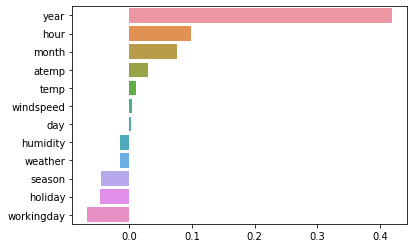

In [30]:
coef = pd.Series(lr_reg.coef_, index=x_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

year 의 회귀 계수 값이 독보적으로 큼. 년도가 대여 횟수에 영향 받는다는 것은 납득하기 어려움.  
year 피처는 연도를 뜻하므로 카테고리(category)형 피처지만, 숫자형 값으로 되어 있음.  
더군다나 아주 큰 값인 2011, 2012로 되어 있음.  
사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 함.  


 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에   
 크게 영향을 받는 경우가 발생할 수 있음.  
 이러한 피처에 **원-핫 인코딩**을 적용해 변환 해야 함.

In [31]:
# year, month, day hour 등의 피처를 One-Hot Encoding
x_features_one = pd.get_dummies(x_features, columns=['year', 'month', 'hour', 'holiday', 'workingday'
                                                    , 'season', 'weather'])

In [33]:
# 원핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습 / 예측 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x_features_one, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 변환
def get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1=False) :
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    
    print('\n### ', model.__class__.__name__, ' ###')
    evaluate_regr(y_test, pred)
# end of func

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.01)

for model in [lr_reg, ridge, lasso] :
    get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1=True)


###  LinearRegression  ###
RMSLE:0.589,  RMSE:97.483, MAE:63.106

###  Ridge  ###
RMSLE:0.589,  RMSE:98.407, MAE:63.648

###  Lasso  ###
RMSLE:0.634,  RMSE:113.031, MAE:72.658


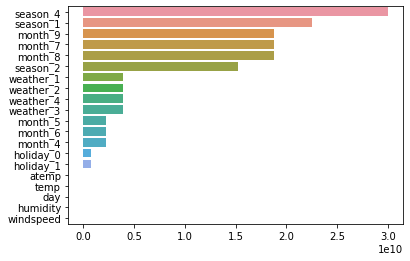

In [34]:
# 원핫 인코딩으로 예측 성능이 향상되었음.
# 원핫 인코딩된 데이터 세트에서 회귀 계수가 높은 상위 피처 20개 시각화
coef = pd.Series(lr_reg.coef_, index=x_features_one.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)
# p.352 부터